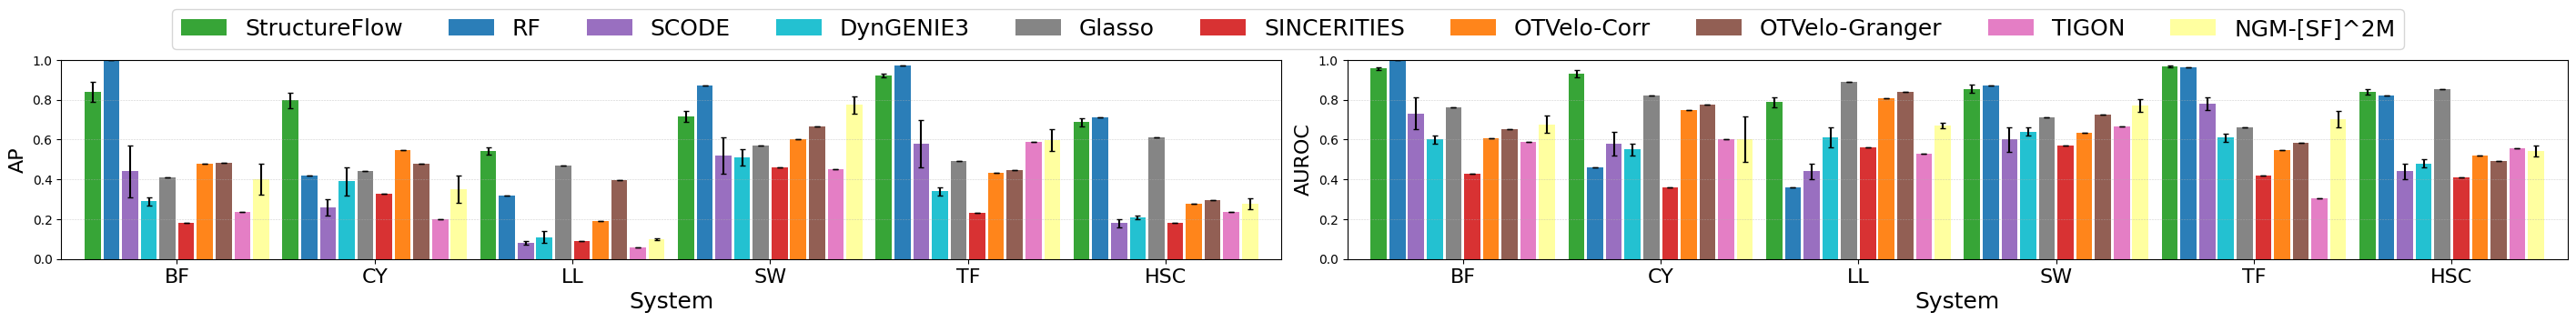

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- load your CSV ---
csv_path = "../src/jobs/results1.csv"  # <-- change to your file path
df = pd.read_csv(csv_path)

# --- ordering & colors to match the figure ---
dataset_order = ["BF", "CY", "LL", "SW", "TF", "HSC"]
method_order  = ["StructureFlow", "RF", "SCODE", "DynGENIE3", "Glasso", "SINCERITIES","OTVelo-Corr", "OTVelo-Granger", "TIGON", "NGM-[SF]^2M"]
colors = {
    "StructureFlow": "#2ca02c",  # green
    "RF": "#1f77b4",             # blue
    "SCODE": "#9467bd",          # purple
    "DynGENIE3": "#17becf",      # teal/cyan
    "Glasso": "#7f7f7f",         # gray
    "SINCERITIES": "#d62728",    # red
    "OTVelo-Corr": "#ff7f0e",    # orange
    "OTVelo-Granger": "#8c564b",  # brown
    "TIGON": "#e377c2",          # pink
    "NGM-[SF]^2M": "#ffff9b"     # sun
}

BAR_WIDTH  = 0.12
INNER_GAP  = 0.02   # tiny gap between adjacent methods within a system
GROUP_GAP  = 0.08   # tiny gap between systems (datasets)

# --- pivot to [dataset x method] for means and stds ---
def make_pivots(df, mean_col, std_col):
    mean_p = (df.pivot(index="dataset", columns="method", values=mean_col)
                .reindex(index=dataset_order, columns=method_order))
    std_p  = (df.pivot(index="dataset", columns="method", values=std_col)
                .reindex(index=dataset_order, columns=method_order))
    return mean_p.fillna(0.0), std_p.fillna(0.0)

AP_mean, AP_std   = make_pivots(df, "AP_mean", "AP_std")
ROC_mean, ROC_std = make_pivots(df, "ROC_AUC_mean", "ROC_AUC_std")

# --- plotting helper (now scales x to fit groups cleanly) ---
def plot_grouped_bars(ax, mean_pivot, std_pivot, ylabel):
    m = len(mean_pivot.columns)
    d = len(mean_pivot.index)
    sep = BAR_WIDTH + INNER_GAP
    group_span = m * sep  # total span of bars (using centers) per dataset

    # space datasets far enough apart so groups don't overlap
    x = np.arange(d) * (group_span + GROUP_GAP)

    for i, method in enumerate(mean_pivot.columns):
        means = mean_pivot[method].values
        stds  = std_pivot[method].values
        pos = x + (i - (m - 1) / 2) * sep
        ax.bar(
            pos, means, BAR_WIDTH,
            label=method,
            yerr=stds, capsize=2,
            color=colors[method], linewidth=0.4, alpha=0.95
        )

    ax.set_xticks(x)
    ax.set_xticklabels(mean_pivot.index, fontsize=16)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel("System", fontsize=18)
    ax.grid(axis="y", linestyle="--", linewidth=0.4, alpha=0.6)
    ax.margins(x=0.02)

# --- dynamic figure width based on methods & datasets ---
m = len(method_order)
d = len(dataset_order)
sep = BAR_WIDTH + INNER_GAP
group_span = m * sep
# 3.2 is a good visual scaling factor for two subplots side-by-side; bump if needed
fig_w = max(18, 3.2 * d * (group_span + GROUP_GAP))

fig, axes = plt.subplots(1, 2, figsize=(fig_w, 3.2), sharey=False)

plot_grouped_bars(axes[0], AP_mean,  AP_std,  "AP")
plot_grouped_bars(axes[1], ROC_mean, ROC_std, "AUROC")

# legend across the top; wrap if it gets too wide by lowering ncol
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(method_order),
           loc="upper center", bbox_to_anchor=(0.5, 1.13), frameon=True, fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# optional: save to file
fig.savefig("ap_auroc_barplot.pdf", dpi=300, bbox_inches="tight")
